---
# ***环境配置与数据集下载***

# 环境信息
- **MindSpore版本**: `2.5.0`
- **CANN版本**: `8.0`
- **设备**: `Ascend`


## 安装seaborn库

In [8]:
!pip install seaborn

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/


## 创建10G的Swap文件

In [ ]:
!sudo fallocate -l 10G /swapfile

# 设置Swap文件权限


In [ ]:
!sudo chmod 600 /swapfile

# 格式化Swap文件

In [ ]:
!sudo mkswap /swapfile

# 启用Swap

In [ ]:
!sudo swapon /swapfile

# 数据集下载链接

In [ ]:
https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# 下载解压完成后存放格式如下
.dataset/  
    ├── Normal/  
    └── Tuberculosis/

---
# ***模型构建***

# 一.激活函数构建
### hsigmoid 计算公式

$$
h\text{-}sigmoid(x) = \frac{\text{ReLU6}(x + 3)}{6}
$$

### hswish 计算公式

$$
h\text{-}swish(x) = x \cdot h\text{-}sigmoid(x)
$$

In [1]:
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore as ms

class HSigmoid(nn.Cell):
    def __init__(self):
        super(HSigmoid, self).__init__()
        self.relu6 = nn.ReLU6()

    def construct(self, x):
        return self.relu6(x + 3.) / 6.

class HSwish(nn.Cell):
    def __init__(self):
        super(HSwish, self).__init__()
        self.hsigmoid = HSigmoid()

    def construct(self, x):
        return x * self.hsigmoid(x)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# 二.SE 模块

SE 模块（Squeeze-and-Excitation Module）通过显式建模通道之间的依赖关系，动态调整每个通道的重要性权重。

---

## 输入特征图

假设输入特征图为 $ X \in \mathbb{R}^{H \times W \times C} $，其中：
- $ H $: 输入特征图的高度
- $ W $: 输入特征图的宽度
- $ C $: 输入特征图的通道数

---

## 1. Squeeze 操作

Squeeze 操作通过全局平均池化（Global Average Pooling, GAP）将每个通道的空间信息压缩为一个标量值，得到一个描述每个通道全局信息的向量 $ z \in \mathbb{R}^C $。

$$
z_c = \frac{1}{H \cdot W} \sum_{i=1}^H \sum_{j=1}^W x_c(i, j), \quad c = 1, 2, \dots, C
$$

其中：
- $ x_c(i, j) $: 第 $ c $ 个通道在位置 $ (i, j) $ 的特征值。
- $ z_c $: 第 $ c $ 个通道的全局统计值。

最终得到的 $ z \in \mathbb{R}^C $ 是一个长度为 $ C $ 的向量。

---

## 2. Excitation 操作

Excitation 操作通过两层全连接网络生成通道的权重 $ s \in \mathbb{R}^C $，用于重新校准每个通道的重要性。

### 第一层全连接（降维）

将 $ z $ 映射到一个低维空间，维度为 $ C/r $，其中 $ r $ 是缩减比例（reduction ratio）。通常 $ r $ 的取值为 16 或其他超参数。

$$
w_1 = \delta(W_1 \cdot z)
$$

其中：
- $ W_1 \in \mathbb{R}^{(C/r) \times C} $: 第一层全连接的权重矩阵。
- $ \delta(\cdot) $: 非线性激活函数（通常为 ReLU）。

### 第二层全连接（升维）

将低维表示映射回原始通道维度 $ C $。

$$
w_2 = \sigma(W_2 \cdot w_1)
$$

其中：
- $ W_2 \in \mathbb{R}^{C \times (C/r)} $: 第二层全连接的权重矩阵。
- $ \sigma(\cdot) $: 激活函数（通常为 Sigmoid），用于生成归一化的权重。

最终得到的 $ s \in \mathbb{R}^C $ 是每个通道的权重向量，满足 $ s_c \in [0, 1] $。

---

## 3. Scale 操作

将生成的权重 $ s $ 应用到原始特征图 $ X $ 上，得到重新加权后的特征图 $ \tilde{X} $。

$$
\tilde{x}_c(i, j) = s_c \cdot x_c(i, j), \quad c = 1, 2, \dots, C
$$

其中：
- $ \tilde{x}_c(i, j) $: 加权后的第 $ c $ 个通道在位置 $ (i, j) $ 的特征值。
- $ s_c $: 第 $ c $ 个通道的权重。

最终输出的特征图 $ \tilde{X} \in \mathbb{R}^{H \times W \times C} $ 是经过通道注意力机制调整后的特征图。

---

## 总结公式

整个 SE 模块的计算可以总结为以下步骤：

1. **Squeeze**:
   $$
   z_c = \frac{1}{H \cdot W} \sum_{i=1}^H \sum_{j=1}^W x_c(i, j)
   $$

2. **Excitation**:
   $$
   w_1 = \delta(W_1 \cdot z)
   $$
   $$
   w_2 = \sigma(W_2 \cdot w_1)
   $$

3. **Scale**:
   $$
   \tilde{x}_c(i, j) = s_c \cdot x_c(i, j)
   $$

---

## 超参数说明

- **缩减比例 $ r $**: 控制 Excitation 操作中降维的比例，通常取值为 16。较大的 $ r $ 会减少计算量，但可能损失部分表达能力。
- **激活函数**:
  - 第一层全连接使用 ReLU 激活函数：$ \delta(x) = \max(0, x) $。
  - 第二层全连接使用 Sigmoid 激活函数：$ \sigma(x) = \frac{1}{1 + e^{-x}} $。

---

In [2]:
class SEBlock(nn.Cell):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = ops.ReduceMean(keep_dims=True)
        self.fc1 = nn.Dense(in_channels, in_channels // reduction, has_bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Dense(in_channels // reduction, in_channels, has_bias=True)
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        out = self.avg_pool(x, (2, 3))  # 全局平均池化，将空间维度压缩为 1x1
        out = out.view(out.shape[0], -1)  # 展平
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.shape[0], out.shape[1], 1, 1)  # 恢复形状
        return x * out

# 三.MobileNetV3 中的倒残差结构（Inverted Residual Block）

倒残差结构（Inverted Residual Block）是 MobileNetV3 的核心组成部分，继承自 MobileNetV2，并在此基础上进行了优化和改进。其主要特点是通过扩展（expand）、深度可分离卷积（depthwise separable convolution）和压缩（squeeze）来实现高效的特征提取。

---

## 倒残差结构的组成

倒残差结构的核心思想包括以下步骤：
1. **扩展（Expand）**: 使用 1x1 卷积将输入通道数扩展到更高的维度。
2. **深度可分离卷积（Depthwise Convolution）**: 对扩展后的特征图进行空间上的卷积操作。
3. **压缩（Squeeze）**: 使用 1x1 卷积将通道数压缩回较低的维度。
4. **残差连接（Residual Connection）**: 如果输入和输出的形状一致，则添加残差连接。

---

## 输入特征图

假设输入特征图为 $ X \in \mathbb{R}^{H \times W \times C_{\text{in}}} $，其中：
- $ H $: 输入特征图的高度
- $ W $: 输入特征图的宽度
- $ C_{\text{in}} $: 输入特征图的通道数

---

## 1. 扩展（Expand）

使用 1x1 卷积将输入通道数从 $ C_{\text{in}} $ 扩展到 $ t \cdot C_{\text{in}} $，其中 $ t $ 是扩展因子（expansion factor）。通常 $ t > 1 $。

$$
X_{\text{expanded}} = \text{Conv}_{1\times1}(X)
$$

- 输出特征图的形状为 $ H \times W \times (t \cdot C_{\text{in}}) $。
- 激活函数通常为 ReLU 或 ReLU6。

---

## 2. 深度可分离卷积（Depthwise Convolution）

对扩展后的特征图进行深度可分离卷积，以减少计算量。深度可分离卷积分为两步：
1. **深度卷积（Depthwise Convolution）**: 对每个通道独立进行卷积操作。
2. **逐点卷积（Pointwise Convolution）**: 使用 1x1 卷积调整通道数。

$$
X_{\text{dw}} = \text{DepthwiseConv}_{k \times k}(X_{\text{expanded}})
$$

- $ k \times k $: 卷积核大小（通常为 3x3）。
- 输出特征图的形状保持不变：$ H \times W \times (t \cdot C_{\text{in}}) $。
- 激活函数通常为 ReLU 或 ReLU6。

---

## 3. 压缩（Squeeze）

使用 1x1 卷积将通道数从 $ t \cdot C_{\text{in}} $ 压缩回 $ C_{\text{out}} $。

$$
X_{\text{squeezed}} = \text{Conv}_{1\times1}(X_{\text{dw}})
$$

- 输出特征图的形状为 $ H \times W \times C_{\text{out}} $。
- 激活函数通常为 **线性激活函数**（即无激活函数），尤其是在压缩阶段。

---

## 4. 残差连接（Residual Connection）

如果输入和输出的形状一致（即 $ C_{\text{in}} = C_{\text{out}} $ 且空间尺寸未改变），则添加残差连接：

$$
Y =
\begin{cases}
    X + X_{\text{squeezed}}, & \text{if } C_{\text{in}} = C_{\text{out}} \text{ and spatial size unchanged} \\
    X_{\text{squeezed}}, & \text{otherwise}
\end{cases}
$$

---

## MobileNetV3 的改进

相比于 MobileNetV2，MobileNetV3 在倒残差结构中引入了以下改进：

### 1. SE 模块（Squeeze-and-Excitation Module）
- 在深度可分离卷积之后、压缩之前，加入 SE 模块，显式建模通道之间的依赖关系。
- SE 模块的计算公式如下：
  $$
  z_c = \frac{1}{H \cdot W} \sum_{i=1}^H \sum_{j=1}^W x_c(i, j)
  $$
  $$
  w_1 = \delta(W_1 \cdot z), \quad w_2 = \sigma(W_2 \cdot w_1)
  $$

### 2. 非线性激活函数的变化
- 在压缩阶段，使用线性激活函数（无激活）。
- 在其他阶段，使用 **h-swish** 激活函数代替 ReLU6，以提高非线性表达能力。

h-swish 的公式为：
$$
\text{h-swish}(x) = x \cdot \frac{\text{ReLU6}(x + 3)}{6}
$$

### 3. 网络结构调整
- MobileNetV3 使用 NAS（神经架构搜索）技术优化了网络结构，包括倒残差块的数量、扩展因子 $ t $ 和通道数 $ C_{\text{out}} $。

---


In [3]:
class Bottleneck(nn.Cell):
    def __init__(self, in_channels, out_channels, exp_size, kernel_size, stride, use_se, use_hs):
        super(Bottleneck, self).__init__()
        self.use_se = use_se
        self.use_hs = use_hs
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels, exp_size, kernel_size=1, has_bias=False)
        self.bn1 = nn.BatchNorm2d(exp_size)
        self.conv2 = nn.Conv2d(exp_size, exp_size, kernel_size=kernel_size, stride=stride,
                           pad_mode='same', group=exp_size, has_bias=False)
        self.bn2 = nn.BatchNorm2d(exp_size)
        self.conv3 = nn.Conv2d(exp_size, out_channels, kernel_size=1, has_bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels) if use_se else None
        self.relu = nn.ReLU()
        self.hs = nn.HSwish()
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, has_bias=False) if in_channels!= out_channels else None
        self.bn_identity = nn.BatchNorm2d(out_channels) if in_channels!= out_channels else None

    def construct(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.use_se:
            out = self.se(out)
        if self.identity is not None:
            identity = self.identity(x)
            identity = self.bn_identity(identity)
        else:
            identity = x
        out = out + identity  # 残差连接
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        return out

# 四.MobileNetV3 主干网络

MobileNetV3 是一种轻量级卷积神经网络，专为移动设备设计，具有高效性和高性能的特点。其主干网络由多个 **倒残差块（Inverted Residual Blocks）** 和其他优化模块组成。

---

## 主要组成部分

1. **初始卷积层（Initial Convolution Layer）**:
   - 使用一个标准的 3x3 卷积层进行特征提取，并通过步幅（stride）减小空间尺寸。
   - 激活函数通常为 h-swish。

2. **倒残差块（Inverted Residual Blocks）**:
   - 核心模块，包含扩展（expand）、深度可分离卷积（depthwise convolution）和压缩（squeeze）。
   - 部分倒残差块中引入了 **SE 模块（Squeeze-and-Excitation Module）**。

3. **全局平均池化（Global Average Pooling, GAP）**:
   - 在网络末端使用全局平均池化将特征图的空间维度压缩为 1x1。

4. **分类头（Classification Head）**:
   - 包括一个全连接层和 Softmax 激活函数，用于分类任务。

---

## MobileNetV3 的改进点

相比于 MobileNetV2，MobileNetV3 引入了以下改进：
1. **SE 模块（Squeeze-and-Excitation Module）**:
   - 在部分倒残差块中加入 SE 模块，显式建模通道之间的依赖关系。
2. **h-swish 激活函数**:
   - 替代 ReLU6，提升非线性表达能力。
   - 公式如下：
     $$
     \text{h-swish}(x) = x \cdot \frac{\text{ReLU6}(x + 3)}{6}
     $$
3. **NAS（神经架构搜索）**:
   - 使用 NAS 技术优化网络结构，包括倒残差块的数量、扩展因子和通道数。
4. **轻量化设计**:
   - MobileNetV3-Small 和 MobileNetV3-Large 分别针对不同计算资源进行了优化。

---

## MobileNetV3 主干网络的结构

以下是 MobileNetV3 主干网络的典型结构（以 MobileNetV3-Large 为例）：

| **Layer**               | **Operator**                     | **Output Size**       | **#Channels** |
|--------------------------|----------------------------------|-----------------------|---------------|
| Initial Conv             | Conv 3x3, stride 2, h-swish      | 112 x 112            | 16            |
| Bottleneck Block 1       | Inverted Residual, SE, h-swish   | 112 x 112            | 16 → 16       |
| Bottleneck Block 2       | Inverted Residual, SE, h-swish   | 56 x 56              | 16 → 24       |
| Bottleneck Block 3       | Inverted Residual, SE, h-swish   | 56 x 56              | 24 → 24       |
| Bottleneck Block 4       | Inverted Residual, SE, h-swish   | 28 x 28              | 24 → 40       |
| Bottleneck Block 5       | Inverted Residual, SE, h-swish   | 28 x 28              | 40 → 40       |
| Bottleneck Block 6       | Inverted Residual, SE, h-swish   | 14 x 14              | 40 → 80       |
| Bottleneck Block 7       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 8       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 9       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 10      | Inverted Residual, SE, h-swish   | 7 x 7                | 80 → 112      |
| Bottleneck Block 11      | Inverted Residual, SE, h-swish   | 7 x 7                | 112 → 112     |
| Bottleneck Block 12      | Inverted Residual, SE, h-swish   | 7 x 7                | 112 → 160     |
| Bottleneck Block 13      | Inverted Residual, SE, h-swish   | 7 x 7                | 160 → 160     |
| Final Conv               | Conv 1x1, h-swish                | 7 x 7                | 160 → 960     |
| Global Average Pooling   | GAP                              | 1 x 1                | 960           |
| Fully Connected          | FC, Softmax                      | Classification Output| #Classes      |

---

## MobileNetV3-Small 和 MobileNetV3-Large 的区别

| **Feature**              | **MobileNetV3-Small**            | **MobileNetV3-Large** |
|--------------------------|----------------------------------|-----------------------|
| 输入分辨率               | 较低（如 224x224 或更低）        | 较高（如 224x224 或更高） |
| 倒残差块数量             | 较少                             | 较多                  |
| 扩展因子                 | 较小（节省计算资源）             | 较大（提高精度）      |
| 参数量                   | 约 2.9M                          | 约 5.4M               |
| 计算量（FLOPs）          | 约 0.055B                        | 约 0.217B             |

---


In [4]:
class MobileNetV3(nn.Cell):
    def __init__(self, num_classes=2, mode='large', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        self.cfgs = []
        if mode == 'large':
            self.cfgs = [
                # k, exp, c,  se,     nl,  s
                [3, 16, 16, False, 'RE', 1],
                [3, 64, 24, False, 'RE', 2],
                [3, 72, 24, False, 'RE', 1],
                [5, 72, 40, True, 'RE', 2],
                [5, 120, 40, True, 'RE', 1],
                [5, 120, 40, True, 'RE', 1],
                [3, 240, 80, False, 'HS', 2],
                [3, 200, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 480, 112, True, 'HS', 1],
                [3, 672, 112, True, 'HS', 1],
                [5, 672, 160, True, 'HS', 2],
                [5, 960, 160, True, 'HS', 1],
                [5, 960, 160, True, 'HS', 1],
            ]
            self.last_channels = 960
        else:  # mode == 'small'
            self.cfgs = [
                # k, exp, c,  se,     nl,  s
                [3, 16, 16, True, 'RE', 2],
                [3, 72, 24, False, 'RE', 2],
                [3, 88, 24, False, 'RE', 1],
                [5, 96, 40, True, 'HS', 2],
                [5, 240, 40, True, 'HS', 1],
                [5, 240, 40, True, 'HS', 1],
                [5, 120, 48, True, 'HS', 1],
                [5, 144, 48, True, 'HS', 1],
                [5, 288, 96, True, 'HS', 2],
                [5, 576, 96, True, 'HS', 1],
                [5, 576, 96, True, 'HS', 1],
            ]
            self.last_channels = 576
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = []
        layers.append(nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, pad_mode='pad', has_bias=False))
        layers.append(nn.BatchNorm2d(input_channel))
        if mode == 'large':
            layers.append(nn.HSwish())
        else:
            layers.append(nn.ReLU())
        for k, exp, c, se, nl, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_channel = _make_divisible(exp * width_mult, 8)
            use_hs = nl == 'HS'
            use_se = se
            layers.append(Bottleneck(input_channel, output_channel, exp_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        last_channel = _make_divisible(self.last_channels * width_mult, 8) if width_mult > 1.0 else self.last_channels
        layers.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, has_bias=False))
        layers.append(nn.BatchNorm2d(last_channel))
        if mode == 'large':
            layers.append(nn.HSwish())
        else:
            layers.append(nn.ReLU())
        self.features = nn.SequentialCell(layers)
        self.avgpool = ops.ReduceMean(keep_dims=True)
        self.classifier = nn.Dense(last_channel, num_classes)

    def construct(self, x):
        x = self.features(x)
        x = self.avgpool(x, (2, 3))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# 五、网络测试
## 打印出我们的网络结构并且创建一个张量对网络进行测试
## 使用numpy的random.randn函数生成一个形状为(1, 3, 224, 224)的随机数组，数组中的元素服从标准正态分布。
## 这里的(1, 3, 224, 224)表示一个批量大小为 1、通道数为 3、高度和宽度均为 224 的图像数据。
## 通过测试查看我们的网络结构是否正确，参数是否正确。

In [5]:
import numpy as np
from mindspore import Tensor
# 实例化模型
model = MobileNetV3(num_classes=2, mode='large', width_mult=1.0)

# 打印模型结构
print("模型结构：")
print(model)

# 测试模型是否可用
dummy_input = Tensor(np.random.randn(1, 3, 224, 224).astype(np.float32))
try:
    output = model(dummy_input)
    print("模型输出形状：", output.shape)
    print("模型测试成功！")
except Exception as e:
    print("模型测试失败，错误信息：", str(e))

模型结构：
MobileNetV3<
  (features): SequentialCell<
    (0): Conv2d<input_channels=3, output_channels=16, kernel_size=(3, 3), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0xfffee7890910>, bias_init=None, format=NCHW>
    (1): BatchNorm2d<num_features=16, eps=1e-05, momentum=0.9, gamma=Parameter (name=features.1.gamma, shape=(16,), dtype=Float32, requires_grad=True), beta=Parameter (name=features.1.beta, shape=(16,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=features.1.moving_mean, shape=(16,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=features.1.moving_variance, shape=(16,), dtype=Float32, requires_grad=False)>
    (2): HSwish<>
    (3): Bottleneck<
      (conv1): Conv2d<input_channels=16, output_channels=16, kernel_size=(1, 1), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.ini

---
# ***模型训练***

# 一、数据划分
## 划分数据集，将原本的数据集格式  
.dataset/  
├── Normal/  
└── Tuberculosis/  
## 划分为  
.dataset/  
├── train/  
 |   ├── Normal/  
 |   └── Tuberculosis/  
├── test  
 |   ├── Normal/  
 |   └── Tuberculosis/  
└── val  
    ├── Normal/  
    └── Tuberculosis/  

In [6]:
import mindspore.dataset.vision.c_transforms as c_vision
import mindspore.dataset.transforms.c_transforms as c_transforms
from mindspore.dataset import ImageFolderDataset
import mindspore.nn as nn
from mindspore.train import Model, LossMonitor, Accuracy
import os
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, auc, precision_recall_curve, classification_report
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import mindspore.ops as ops
import mindspore as ms

def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    normal_dir = os.path.join(data_dir, 'Normal')
    tuberculosis_dir = os.path.join(data_dir, 'Tuberculosis')
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # 创建目录
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'Tuberculosis'), exist_ok=True)

    # 获取文件列表
    normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
    tuberculosis_files = [os.path.join(tuberculosis_dir, f) for f in os.listdir(tuberculosis_dir)]

    # 打乱文件列表
    random.shuffle(normal_files)
    random.shuffle(tuberculosis_files)

    def split_files(files, train_size, val_size):
        train_files = files[:train_size]
        val_files = files[train_size:train_size + val_size]
        test_files = files[train_size + val_size:]
        return train_files, val_files, test_files

    # 计算划分数量
    num_normal = len(normal_files)
    num_tuberculosis = len(tuberculosis_files)
    train_normal_size = int(num_normal * train_ratio)
    val_normal_size = int(num_normal * val_ratio)
    test_normal_size = num_normal - train_normal_size - val_normal_size
    train_tuberculosis_size = int(num_tuberculosis * train_ratio)
    val_tuberculosis_size = int(num_tuberculosis * val_ratio)
    test_tuberculosis_size = num_tuberculosis - train_tuberculosis_size - val_tuberculosis_size

    # 划分正常图像
    train_normal, val_normal, test_normal = split_files(normal_files, train_normal_size, val_normal_size)
    # 划分肺结核图像
    train_tuberculosis, val_tuberculosis, test_tuberculosis = split_files(tuberculosis_files, train_tuberculosis_size, val_tuberculosis_size)

    def copy_files(files, dst_dir):
        for file in files:
            shutil.copy(file, dst_dir)

    # 复制正常图像
    copy_files(train_normal, os.path.join(train_dir, 'Normal'))
    copy_files(val_normal, os.path.join(val_dir, 'Normal'))
    copy_files(test_normal, os.path.join(test_dir, 'Normal'))
    # 复制肺结核图像
    copy_files(train_tuberculosis, os.path.join(train_dir, 'Tuberculosis'))
    copy_files(val_tuberculosis, os.path.join(val_dir, 'Tuberculosis'))
    copy_files(test_tuberculosis, os.path.join(test_dir, 'Tuberculosis'))

# 二、数据预处理与数据载入
这段代码定义了两个函数 `preprocess_dataset` 和 `load_datasets`，用于加载和预处理图像数据明。

---

## 1. 函数 `preprocess_dataset`

该函数的主要功能是对指定目录中的图像数据集进行加载和预处理，并返回一个批处理的数据集对象。

### 参数说明
- **`dataset_dir`**: 数据集所在的目录路径。
- **`batch_size`**: 批处理大小，默认值为 `32`。
- **`image_size`**: 图像的目标尺寸，默认为 `(512, 512)`。
- **`train`**: 布尔值，指示是否为训练数据集。如果为 `True`，则应用数据增强操作；否则使用验证/测试数据的预处理方式。

### 主要步骤

1. **加载数据集**:
   dataset = ImageFolderDataset(dataset_dir, num_parallel_workers=4)  
   
2. **定义标准化参数**:  
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]  
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]  
    
3.  **定义图像预处理操作**：
根据`train`的参数不同，选择不同的预处理流水线:
- **训练数据**：
   ```python
    trans = [
        c_vision.RandomCropDecodeResize(image_size),
        c_vision.RandomHorizontalFlip(prob=0.5),
        c_vision.Normalize(mean=mean, std=std),
        c_vision.HWC2CHW()
    ]
- **`RandomCropDecodeResize`**: 随机裁剪并调整图像大小到目标尺寸 `(512, 512)`。
- **`RandomHorizontalFlip`**:以 50% 的概率水平翻转图像，用于数据增强。
- **`Normalize`**:  对图像进行归一化处理。
- **`HWC2CHW`**: 将图像从 HWC（高度、宽度、通道）格式转换为 CHW（通道、高度、宽度）格式，这是深度学习框架中常见的输入格式。
4.  **验证/测试数据 :**
     ```python
    trans = [
        c_vision.Decode(),
        c_vision.Resize(image_size),
        c_vision.CenterCrop(image_size),
        c_vision.Normalize(mean=mean, std=std),
        c_vision.HWC2CHW()
    ]
- **`Decode`**: 解码图像。
- **`Resize`**: 调整图像大小到目标尺寸。
- **`CenterCrop`**: 从中心裁剪图像到目标尺寸。
- 其余操作与训练数据相同。


## 2. 函数 `load_datasets`
该函数的主要功能是调用 preprocess_dataset 函数，分别加载训练集、验证集和测试集，并返回它们。
### 主要步骤

1. **加载训练集**:  
    train_dataset = preprocess_dataset("dataset/train", batch_size=batch_size, image_size=(512, 512), train=True)  
    调用 **`preprocess_dataset`** 加载训练集，并启用数据增强。  
2. **加载验证集**:  
    val_dataset = preprocess_dataset("dataset/val", batch_size=batch_size, image_size=(512, 512), train=False)   
    调用 **`preprocess_dataset`** 加载训练集，不启用数据增强。  
   
4. **加载测试集**:  
    test_dataset = preprocess_dataset("dataset/test", batch_size=batch_size, image_size=(512, 512), train=False)  
    调用 **`preprocess_dataset`** 加载训练集，不启用数据增强。  



In [7]:
def preprocess_dataset(dataset_dir, batch_size=32, image_size=(512, 512), train=True):
    # 加载数据集
    dataset = ImageFolderDataset(dataset_dir, num_parallel_workers=4)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            c_vision.RandomCropDecodeResize(image_size),
            c_vision.RandomHorizontalFlip(prob=0.5),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]
    else:
        trans = [
            c_vision.Decode(),
            c_vision.Resize(image_size),
            c_vision.CenterCrop(image_size),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]
    type_cast_op = c_transforms.TypeCast(ms.int32)
    dataset = dataset.map(operations=trans, input_columns=["image"], num_parallel_workers=4)
    dataset = dataset.map(operations=type_cast_op, input_columns=["label"], num_parallel_workers=4)
    dataset = dataset.batch(batch_size)
    return dataset


def load_datasets(batch_size=32):
    train_dataset = preprocess_dataset("dataset/train", batch_size=batch_size, image_size=(512, 512), train=True)
    val_dataset = preprocess_dataset("dataset/val", batch_size=batch_size, image_size=(512, 512), train=False)
    test_dataset = preprocess_dataset("dataset/test", batch_size=batch_size, image_size=(512, 512), train=False)
    return train_dataset, val_dataset, test_dataset

# 三、模型创建
## 创建模型 (`create_model`)

该函数的主要功能是创建一个基于 MobileNetV3 的深度学习模型，并配置损失函数和优化器，用于二分类任务（正常 vs 肺结核）。

---

## 功能说明
1. **定义模型**:  
     ```python
    model = MobileNetV3(num_classes=2)  
- 使用`MobileNetV3`构建模型。
- 参数`num_classes=2`表示这是一个二分类任务（本样例中为Normal与Tuberculosis）。
  
2. **定义损失函数**:  
     ```python
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True)  
- 使用`SoftmaxCrossEntropyWithLogits`作为损失函数。
- 参数`sparse=True`表示标签是整数形式（例如：0 和 1），而不是 one-hot 编码形式。
  
3. **定义优化器**:  
     ```python
    opt = nn.Momentum(model.trainable_params(), learning_rate=0.01, momentum=0.9)  
- 使用`Momentum`优化器。
- 参数`model.trainable_params()`获取模型中所有可训练的参数。
- 参数`learning_rate=0.01`学习率设置为 0.01。
- 参数`momentum=0.9`动量设置为 0.9，用于加速收敛并减少震荡。

In [8]:
def create_model():
    model = MobileNetV3(num_classes=2)  # 二分类任务：正常 vs 肺结核
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True)
    opt = nn.Momentum(model.trainable_params(), learning_rate=0.01, momentum=0.9)
    return model, loss, opt

# 四、绘制模型评估图

## 功能说明
1. **定义模型**:  
- 使用`MobileNetV3`构建模型，并通过`load_checkpoint`加载预训练权重。
- 设置模型为推理模式（`set_train(False)`）。  
  
2. **检查测试数据**:   
- 如果测试数据集为空，抛出异常以避免后续错误。
- 参数`sparse=True`表示标签是整数形式（例如：0 和 1），而不是 one-hot 编码形式。
 
3. **收集预测结果**:  
- 遍历测试数据集，逐批次获取图像和标签。
- 使用模型对图像进行推理，得到预测结果和概率值。
  
4. **绘制混淆矩阵**:  
- 使用`confusion_matrix`计算混淆矩阵。
- 使用`seaborn.heatmap`绘制混淆矩阵热力图。

5. **绘制 ROC 曲线**:  
- 使用`roc_curve`计算 FPR 和 TPR，以及 AUC 值。
- 绘制 ROC 曲线，并标注 AUC 值。

6. **绘制 PR 曲线**:  
- 使用`precision_recall_curve`计算精确率和召回率。
- 绘制 PR 曲线。

7. **绘制分类报告热力图**:  
- 使用`classification_report`计算分类报告。
- 使用`seaborn.heatmap`绘制热力图。

In [9]:
def generate_evaluation_plots(model_path, test_dataset, save_dir):
    # 加载模型
    model = MobileNetV3(num_classes=2)
    ms.load_checkpoint(model_path, model, strict_load=True)
    model.set_train(False)  # 关键修复：使用 set_train(False)
    
    # 检查测试数据
    if test_dataset.get_dataset_size() == 0:
        raise ValueError("测试数据集为空！")
    
    # 收集预测结果
    true_labels, pred_labels, probs = [], [], []
    for batch in test_dataset.create_dict_iterator():
        images = batch["image"]
        labels = batch["label"]
        outputs = model(images)
        preds = outputs.argmax(axis=1)
        prob = ms.ops.Softmax(axis=1)(outputs)[:, 1].asnumpy()
        true_labels.extend(labels.asnumpy())
        pred_labels.extend(preds.asnumpy())
        probs.extend(prob)
    
    # 1. 混淆矩阵
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Tuberculosis'], 
                yticklabels=['Normal', 'Tuberculosis'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), bbox_inches='tight')
    plt.close()
    
    # 2. ROC曲线
    fpr, tpr, _ = roc_curve(true_labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'), bbox_inches='tight')
    plt.close()
    
    # 3. PR曲线
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='PR Curve')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(os.path.join(save_dir, 'pr_curve.png'), bbox_inches='tight')
    plt.close()
    
    # 4. 分类报告热力图
    report = classification_report(true_labels, pred_labels, target_names=['Normal', 'Tuberculosis'], output_dict=True)
    plt.figure(figsize=(8, 4))
    sns.heatmap([[report['Normal']['precision'], report['Normal']['recall']],
                 [report['Tuberculosis']['precision'], report['Tuberculosis']['recall']]],
                annot=True, cmap='Blues', fmt='.2f',
                xticklabels=['Precision', 'Recall'], 
                yticklabels=['Normal', 'Tuberculosis'])
    plt.title('Classification Report Heatmap')
    plt.savefig(os.path.join(save_dir, 'classification_heatmap.png'), bbox_inches='tight')
    plt.close()

# 五、训练与可视化
1. **创建保存目录**:
   os.makedirs(save_dir, exist_ok=True)  
   - 确保保存图表的目录存在。如果目录不存在，则自动创建。

2. **划分数据集并加载**:
   - 调用 `split_dataset` 函数对数据集进行划分（训练集、验证集、测试集）。
   - 使用 `load_datasets` 函数加载预处理后的数据
  
3. **创建模型、损失函数和优化器**:
   - 使用 `MobileNetV3` 构建二分类模型。
   - 定义损失函数 `SoftmaxCrossEntropyWithLogits`，并设置 `sparse=True` 和 `reduction='mean'`。
   - 定义优化器 `Momentum`，指定学习率和
  
4. **封装训练网络**:
   - 使用 `nn.WithLossCell` 将模型和损失函数封装在一起。
   - 使用 `nn.TrainOneStepCell` 封装训练网络，便于后续调
  
5. **记录训练指标**:
   - 初始化列表 `train_loss_history` 和 `val_accuracy_history`，用于记录每轮的训练损失和验证准确率。
   - 初始化变量 `best_val_accuracy` 和 `best_model_path`，用于保存最佳模
  
6. **训练循环**:
   - 每轮训练分为以下两个阶段：
     - **训练阶段**: 遍历训练数据集，计算每个批次的损失，并更新模型参数。
     - **验证阶段**: 遍历验证数据集，计算模型的准
    
7. **保存最佳模型**:
   - 如果当前验证准确率更高，则删除之前的最佳模型文件，并保存新的最佳模型
  
8. **打印日志**:
   - 打印每轮的训练损失和验证准确率
  
9. **绘制训练过程曲线**:
   - 绘制训练损失曲线和验证准确率曲线，并保存为 `final_training_progress.png`
  
10. **最终评估**:
    
    - 使用测试数据集对最佳模型进行评估，并生成混淆矩阵、ROC 曲线、PR 曲线和分类报告热力图。。。。确率。型。用。动量。集。

In [10]:
def train_and_evaluate(epochs=10, lr=0.001, batch_size=16, save_dir="graphs"):
    os.makedirs(save_dir, exist_ok=True)
    # 划分数据集
    split_dataset('dataset')
    train_dataset, val_dataset, test_dataset = load_datasets(batch_size)
    # 创建模型和优化器
    model = MobileNetV3(num_classes=2)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(model.trainable_params(), learning_rate=lr, momentum=0.9)
    # 封装训练网络
    net_with_loss = nn.WithLossCell(model, loss_fn)
    train_net = nn.TrainOneStepCell(net_with_loss, opt)
    # 记录训练指标
    train_loss_history = []
    val_accuracy_history = []
    best_val_accuracy = 0.0
    best_model_path = None
    # 训练循环
    for epoch in range(epochs):
        # 训练阶段
        model.set_train(True) 
        epoch_loss = 0.0
        progress_bar = tqdm(train_dataset.create_dict_iterator(), 
                            desc=f"Epoch {epoch+1}/{epochs}", 
                            total=len(train_dataset),
                            bar_format="{l_bar}{bar:20}{r_bar}")
        for batch in progress_bar:
            data = batch["image"]
            label = batch["label"]
            loss = train_net(data, label)
            epoch_loss += loss.asnumpy().item()
            progress_bar.set_postfix({"Batch Loss": loss.asnumpy().item()})
        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_loss_history.append(avg_epoch_loss)

        # 验证阶段
        model.set_train(False)  # 关键修复：使用 set_train(False)
        acc_metric = Accuracy()
        val_progress = tqdm(val_dataset.create_dict_iterator(), 
                            desc="Validating", 
                            total=len(val_dataset), 
                            leave=False)
        for batch in val_progress:
            data = batch["image"]
            label = batch["label"]
            output = model(data)
            acc_metric.update(output, label)
        val_accuracy = acc_metric.eval()
        val_accuracy_history.append(val_accuracy)

        # 保存最佳模型
        if val_accuracy > best_val_accuracy:
            if best_model_path: 
                os.remove(best_model_path)
            best_val_accuracy = val_accuracy
            best_model_path = f"best_model_epoch_{epoch+1}.ckpt"
            ms.save_checkpoint(model, best_model_path)

        # 打印日志
        print(f"\nEpoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_epoch_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

    # 训练结束后绘制完整的 loss 和 accuracy 图
    plt.figure(figsize=(12, 5))
    
    # 绘制训练 loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss', color='blue')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 绘制验证 accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_accuracy_history, label='Validation Accuracy', color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # 保存最终的训练结果图
    plt.savefig(os.path.join(save_dir, 'final_training_progress.png'), bbox_inches='tight')
    plt.close()

    # 最终评估
    generate_evaluation_plots(best_model_path, test_dataset, save_dir)

In [11]:
train_and_evaluate(
        epochs=10, 
        lr=0.001,  # 适当增大学习率
        batch_size=32,
        save_dir="graphs"
    )

[WARNING] ME(35726:281473698680864,MainProcess):2025-03-03-06:33:33.239.3 [mindspore/dataset/core/validator_helpers.py:744] 'RandomCropDecodeResize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCropDecodeResize' from mindspore.dataset.vision instead.
[WARNING] ME(35726:281473698680864,MainProcess):2025-03-03-06:33:33.367.2 [mindspore/dataset/core/validator_helpers.py:744] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(35726:281473698680864,MainProcess):2025-03-03-06:33:33.440.6 [mindspore/dataset/core/validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(35726:281473698680864

.....

Validating:   0%|          | 0/37 [00:00<?, ?it/s]

.


Epoch [1/10] Train Loss: 0.4441, Val Acc: 0.8325


Epoch 2/10: 100%|████████████████████| 120/120 [00:33<00:00,  3.60it/s, Batch Loss=0.227]



Epoch [2/10] Train Loss: 0.3319, Val Acc: 0.8325


Epoch 3/10: 100%|████████████████████| 120/120 [00:35<00:00,  3.36it/s, Batch Loss=0.322]



Epoch [3/10] Train Loss: 0.2988, Val Acc: 0.8670


Epoch 4/10: 100%|████████████████████| 120/120 [00:31<00:00,  3.77it/s, Batch Loss=0.384]



Epoch [4/10] Train Loss: 0.3045, Val Acc: 0.8644


Epoch 5/10: 100%|████████████████████| 120/120 [00:33<00:00,  3.56it/s, Batch Loss=0.134] 



Epoch [5/10] Train Loss: 0.2425, Val Acc: 0.9439


Epoch 6/10: 100%|████████████████████| 120/120 [00:38<00:00,  3.14it/s, Batch Loss=0.138] 



Epoch [6/10] Train Loss: 0.1847, Val Acc: 0.9249


Epoch 7/10: 100%|████████████████████| 120/120 [00:33<00:00,  3.53it/s, Batch Loss=0.156] 



Epoch [7/10] Train Loss: 0.1676, Val Acc: 0.9465


Epoch 8/10: 100%|████████████████████| 120/120 [00:34<00:00,  3.43it/s, Batch Loss=0.13]  



Epoch [8/10] Train Loss: 0.1546, Val Acc: 0.9301


Epoch 9/10: 100%|████████████████████| 120/120 [00:36<00:00,  3.27it/s, Batch Loss=0.0882]



Epoch [9/10] Train Loss: 0.1445, Val Acc: 0.9551


Epoch 10/10: 100%|████████████████████| 120/120 [00:33<00:00,  3.58it/s, Batch Loss=0.0592]



Epoch [10/10] Train Loss: 0.1429, Val Acc: 0.9033
.

# 六、预测

## 需要自行修改**model_path**与**test_image_path**路径

预测类别: Normal
类别概率: Normal: 0.9975, Tuberculosis: 0.0025


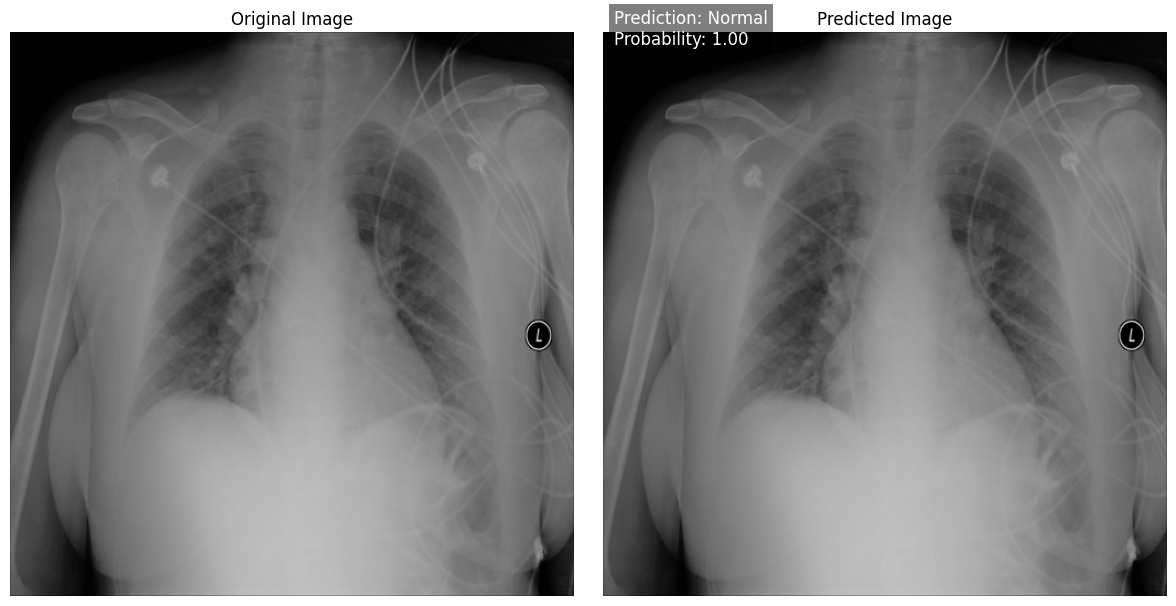

In [12]:
# 加载必要的库
import os
import numpy as np
from PIL import Image
import mindspore as ms
from mindspore import load_checkpoint, load_param_into_net
import matplotlib.pyplot as plt

# 定义模型和加载权重
def load_trained_model(model_path, num_classes=2):
    """
    加载训练好的模型。
    :param model_path: 模型权重文件路径
    :param num_classes: 分类任务的类别数
    :return: 加载权重后的模型
    """
    # 初始化模型
    model = MobileNetV3(num_classes=num_classes)  # 假设您的模型定义为 MobileNetV3
    # 加载权重
    param_dict = load_checkpoint(model_path)
    load_param_into_net(model, param_dict)
    # 设置模型为推理模式
    model.set_train(False)
    return model

# 图像预处理函数
def preprocess_image(image_path, image_size=(512, 512)):
    """
    对输入图像进行预处理。
    :param image_path: 图像文件路径
    :param image_size: 目标图像尺寸
    :return: 预处理后的图像张量
    """
    # 打开图像并调整大小
    image = Image.open(image_path).convert("RGB")
    original_image = image.copy()  # 保存原始图像用于显示
    image = image.resize(image_size)
    # 转换为 NumPy 数组并归一化
    image = np.array(image).astype(np.float32)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    image = (image - mean) / std
    # 转换为 CHW 格式
    image = np.transpose(image, (2, 0, 1))
    # 添加 batch 维度
    image = np.expand_dims(image, axis=0)
    # 转换为 MindSpore Tensor
    image = ms.Tensor(image, dtype=ms.float32)
    return image, original_image

# 推理函数
def predict(model, image_tensor):
    """
    使用模型对输入图像进行预测。
    :param model: 加载好的模型
    :param image_tensor: 预处理后的图像张量
    :return: 预测结果和概率
    """
    # 模型推理
    outputs = model(image_tensor)
    # 计算 softmax 概率
    probs = ms.ops.Softmax(axis=1)(outputs).asnumpy()
    # 获取预测类别
    pred_class = np.argmax(probs, axis=1)[0]
    return pred_class, probs[0]

# 主程序
if __name__ == "__main__":
    # 模型路径
    model_path = "best_model_epoch_9.ckpt"
    # 加载模型
    model = load_trained_model(model_path, num_classes=2)
    
    # 测试图像路径
    test_image_path = "test.png" 
    if not os.path.exists(test_image_path):
        raise FileNotFoundError(f"测试图像文件 {test_image_path} 不存在！")
    
    # 预处理图像
    image_tensor, original_image = preprocess_image(test_image_path)
    
    # 进行预测
    pred_class, probs = predict(model, image_tensor)
    
    # 输出结果
    class_names = ["Normal", "Tuberculosis"]  # 类别名称
    print(f"预测类别: {class_names[pred_class]}")
    print(f"类别概率: Normal: {probs[0]:.4f}, Tuberculosis: {probs[1]:.4f}")
    
    # 使用 matplotlib 显示图像
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 创建两个子图
    
    # 显示原始图像
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")  # 关闭坐标轴
    
    # 显示预测图像
    predicted_image = np.array(original_image)  # 复制原始图像
    axes[1].imshow(predicted_image)
    axes[1].set_title("Predicted Image")
    axes[1].axis("off")  # 关闭坐标轴
    
    # 在预测图像上添加预测标签
    label_text = f"Prediction: {class_names[pred_class]}\nProbability: {probs[pred_class]:.2f}"
    axes[1].text(
        10, 10, label_text, color="white", fontsize=12,
        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
    )
    
    # 显示图像
    plt.tight_layout()
    plt.show()